In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np

from PIL import ImageDraw

plt.ion()   # interactive mode

In [2]:
def get_grid(thetas, idx):
    theta = thetas[idx]
    grid = F.affine_grid(theta.view(1, 2, 3), torch.Size([1, 1, 28, 28]))
    grid = 60*(grid[0] + 1) / 2 # undo normalization of image coordinates
    return grid

def convert_img(single_image):
    single_pil = transforms.ToPILImage()(single_image)
    # clip image, for visualization purposes
    thresh = lambda x : 255 if x > 150 else 0
    single_pil = single_pil.convert('L').point(thresh, mode='1')
    single_pil = single_pil.convert('RGB')
    return single_pil

def draw_box(pil_image, grid):
    draw = ImageDraw.Draw(pil_image)
    # Match colors from the paper
    draw.line([*grid[0][0], *grid[0][-1]], fill='red')
    draw.line([*grid[0][-1], *grid[-1][-1]], fill='green')
    draw.line([*grid[-1][-1], *grid[-1][0]], fill='yellow')
    draw.line([*grid[-1][0], *grid[0][0]], fill='blue')

    return pil_image

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # input is single channel, deepen here
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        # Two FC layers to classify
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # ST localization network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 11 * 11, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    # This also allows for the localization to be called separately on test data
    def stn(self, x):
        theta = self.theta(x)
        # Scale to NxCx28x28, essentially downsizing
        grid = F.affine_grid(theta, torch.Size([x.shape[0], x.shape[1], 28, 28]))
        x = F.grid_sample(x, grid)

        return x

    def theta(self, x):
        xs = self.localization(x)
        # Got this shape by simply running a single forward pass and printing the dimensions of `self.localization`
        xs = xs.view(-1, 10 * 11 * 11)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        return theta

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
def plot_box_on_image(input):
    with torch.no_grad():
        tformed_batch = model.stn(input)
        thetas = model.theta(input)

    single_batch = input.cpu()
    tformed_batch = tformed_batch.cpu()
    thetas = thetas.cpu()

    img = convert_img(single_batch[0,:,:,:])
    grid = get_grid(thetas, 0)
    draw_box(img, grid)
    
    return img

In [79]:
model = Net()
checkpoint = torch.load('weights/checkpoint.pkl')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
data_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root='../../../data/', 
        train=False, 
        transform=transforms.Compose(
            [transforms.Pad(16), transforms.ToTensor()])
        ), 
        batch_size=1, shuffle=True, num_workers=4
    )

In [8]:
def apply_tform(sample, translation=(0,0), rot=0):
    img = transforms.ToPILImage()(sample[0, :, :, :])
    img = transforms.functional.affine(img, rot, translation, 1.0, 0)
    return transforms.ToTensor()(img).reshape(1, 1, 60, 60)


In [67]:
while True:
    x, y = next(iter(data_loader))
    if y == 6:
        break

tensor([6])


In [68]:
x_ = apply_tform(x, (10, 10))

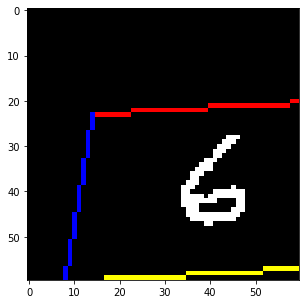

In [69]:
plt.imshow(plot_box_on_image(x_))

In [81]:
imgs = []
for i in range(0, 20, 2):
    x_ = apply_tform(x, (0, i))
    imgs.append(plot_box_on_image(x_))
for i in range(0, 20, 2):
    x_ = apply_tform(x, (i, 20))
    imgs.append(plot_box_on_image(x_))
for i in range(20, -20, -2):
    x_ = apply_tform(x, (i, i))
    imgs.append(plot_box_on_image(x_))
for i in range(-20, 20, 2):
    x_ = apply_tform(x, (i, -20))
    imgs.append(plot_box_on_image(x_))
for i in range(-20, 20, 2):
    x_ = apply_tform(x, (-i, i))
    imgs.append(plot_box_on_image(x_))
for i in range(-20, 0, 2):
    x_ = apply_tform(x, (i, -i))
    imgs.append(plot_box_on_image(x_))
imgs[0].save('gifs/translate.gif', save_all=True, append_images=imgs, loop=1000)

In [78]:
model = Net()
checkpoint = torch.load('weights/rotation_checkpoint.pkl')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [75]:
imgs = []
for i in range(0, 45, 2):
    x_ = apply_tform(x, (0, 0), i)
    imgs.append(plot_box_on_image(x_))
for i in range(45, -45, -2):
    x_ = apply_tform(x, (0, 0), i)
    imgs.append(plot_box_on_image(x_))
imgs[0].save('gifs/rotate.gif', save_all=True, append_images=imgs, loop=1000)